In [158]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [159]:
def f(x):
    return 2*x**2 + 6*x + 8

In [160]:
f(2)

28

In [161]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

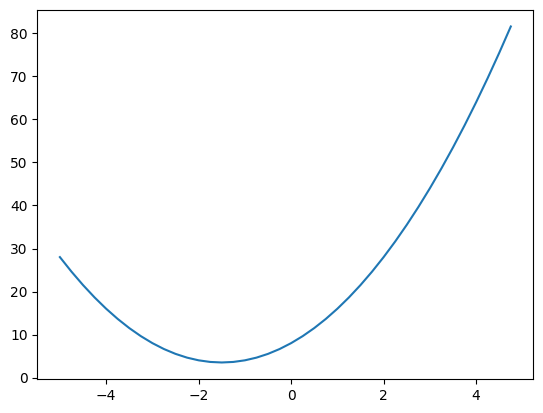

In [162]:
ys = f(xs)
plt.plot(xs, ys)

Numerical Derivative

In [163]:
h = 0.000001
x = -1.50009
der = (f(x+h)-f(x))/h
der

-0.0003580007401637886

Multivariate

In [164]:
a = 2
b = 3
c = 4

d = a*b + c

h = 0.0001

a+=h

der = (((a+h)*b + c) - (a*b +c))/h
der

3.000000000010772

In [165]:
der = (((b+h)*a + c) - (a*b +c))/h
der

2.000100000003613

In [166]:
der = ((a*b + c+h) - (a*b +c))/h
der

0.9999999999976694

Data structure to hold values

In [167]:
class Value:

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        '''
            To print the instances of this class in a required format
        '''
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data)
    
    def __mul__(self, other):
        return Value(self.data * other.data)

    
a = Value(2.0)
b = Value(3.0)
print(a, b)

print(a+b)

print(a*b)

Value(data=2.0) Value(data=3.0)
Value(data=5.0)
Value(data=6.0)


In [168]:
c = Value(4)

print(a*b + c)

Value(data=10.0)


To store previous states of the value and the operations

In [169]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

a = Value(2.0, label='a')
b = Value(3.0, label='b')
c = Value(4, label='c')

e = a*b
e.label = 'e'
d = e + c

f = Value(-2.0, label='f')
L = d + f; L.label = 'L'

d.label = 'd'
d, d._prev, d._op, L

(Value(data=10.0), {Value(data=4), Value(data=6.0)}, '+', Value(data=8.0))

Visualize the computation graph

In [170]:
from graphviz import Digraph

def trace(root):
    "build a set of all nodes and edges in a graph"
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR is left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        #for any value in the graph, create a rectangular ('record') node

        dot.node(name = uid, label = "%s | data %.4f" %(n.label, n.data, ), shape ='record')
        if n._op:
            #if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            #connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connect n1 to op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
                 
    return dot

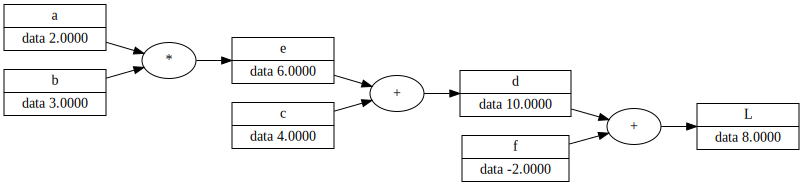

In [171]:
draw_dot(L)

Grad variable

In [172]:
class Value:

    def __init__(self, data, _children=(), _op='', label='', ):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')
    
a = Value(2.0, label='a')
b = Value(3.0, label='b')
c = Value(4.0, label='c')

e = a*b; e.label='e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data=-20.0)

In [173]:
from graphviz import Digraph

def trace(root):
    "build a set of all nodes and edges in a graph"
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR is left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        #for any value in the graph, create a rectangular ('record') node

        dot.node(name = uid, label = "%s | data %.4f | grad %.4f" %(n.label, n.data, n.grad), shape ='record')
        if n._op:
            #if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            #connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connect n1 to op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
                 
    return dot

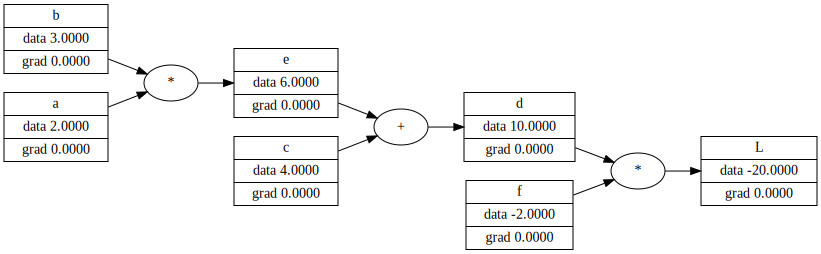

In [174]:
draw_dot(L)

In [175]:
L.grad = 1

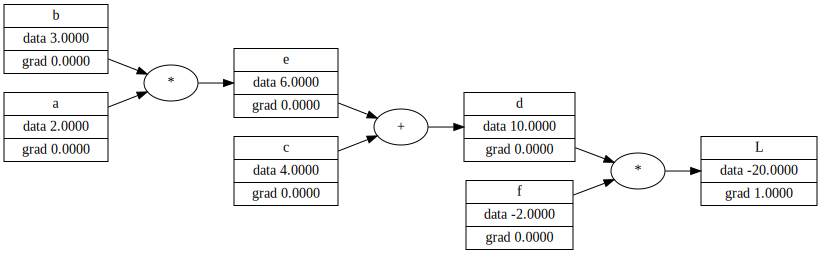

In [176]:
draw_dot(L)

dL/dd = ((d+h)*f - d*f)/h = f

df/dd = (d*(f+h) - d*f)/h = d

In [177]:
d.grad = f.data
f.grad = d.data

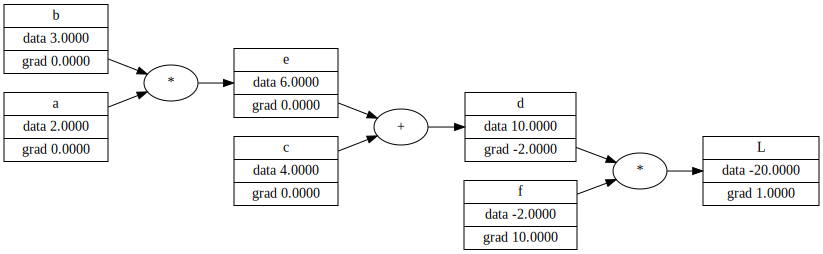

In [178]:
draw_dot(L)

##### BackProp of gradients

dL/dc?

Local derivatives::

dd/dc = 1.0; since d = c + e

dd/de = 1.0

Chain rule::

dL/dc = dL/dd * dd/dc


In [179]:
c.grad = 1.0 * -2.0
e.grad = 1.0 * -2.0

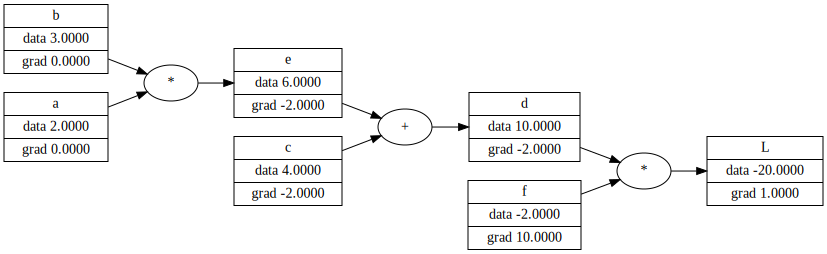

In [180]:
draw_dot(L)

dL/da = dL/de * de/da

In [181]:
a.grad = -2.0 * 3
b.grad = -2.0 * 2

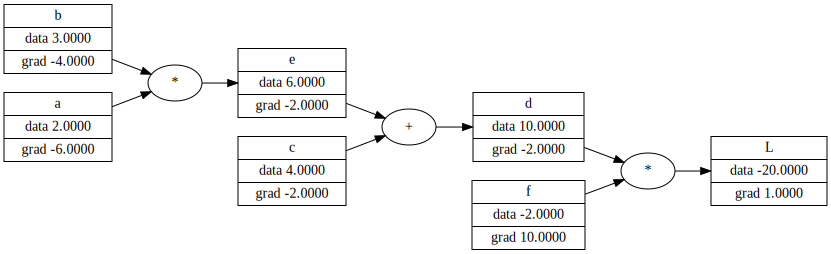

In [182]:
draw_dot(L)

Forward Prop

In [183]:
s = 0.01 #step
a.data += a.grad * s
b.data += b.grad * s
c.data += c.grad * s
f.data += f.grad * s

e = a*b
d = e+c
L = d*f

print(L.data)

-18.47256


Apply backprop to a neuron

tanh activation func

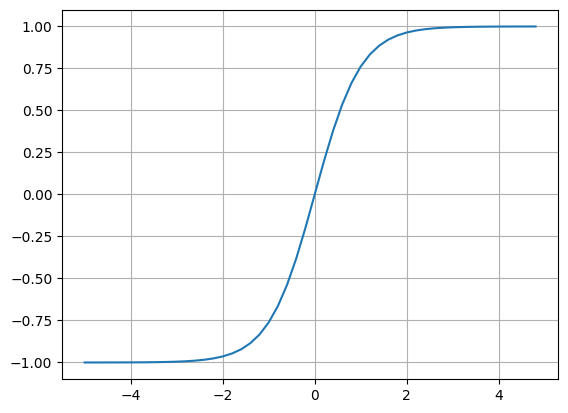

In [184]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

Relu Neuron

In [188]:
class Value:

    def __init__(self, data, _children=(), _op='', label='', ):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        return out
    
a = Value(2.0, label='a')
b = Value(3.0, label='b')
c = Value(4.0, label='c')

e = a*b; e.label='e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data=-20.0)

In [195]:
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias
b = Value(6.88137358, label='b')

#output
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


In [198]:
o.grad = 1.0

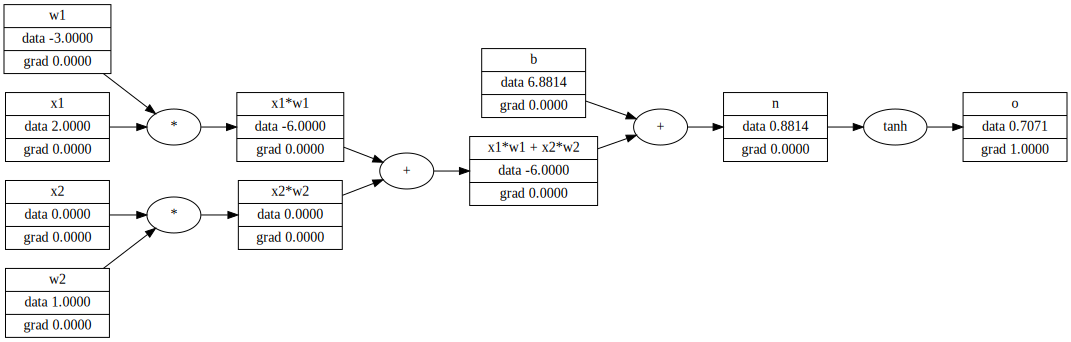

In [199]:
draw_dot(o)

Derviative of tanh::

do/dn = 1 - tanh(n) ** 2 = 1 - o ** 2



In [201]:
n.grad = 1 - o.data**2

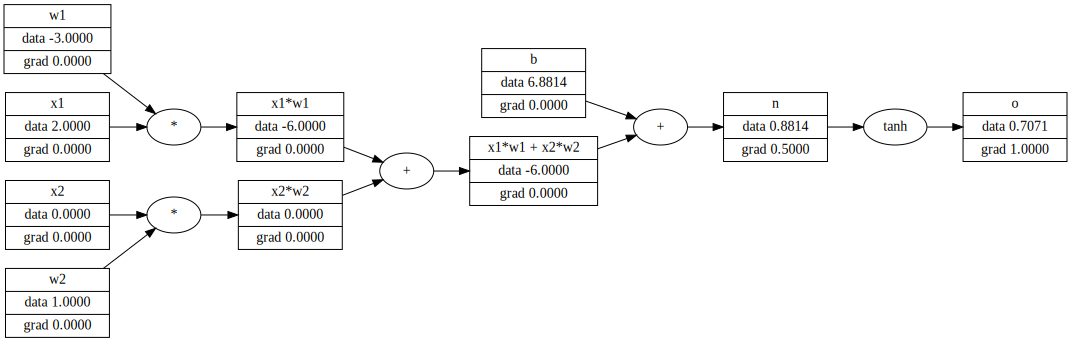

In [202]:
draw_dot(o)

In [204]:
x1w1x2w2.grad = 0.5 #Since local derivative is 1, ie for n = x1w1x2w2 + b: dn/d(x1w1x2w2) = 1
#similarily
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5

In [205]:
x2.grad = w2.data*x2w2.grad
w2.grad = x2.data*x2w2.grad

x1.grad = w1.data*x1w1.grad
w1.grad = x1.data*x1w1.grad

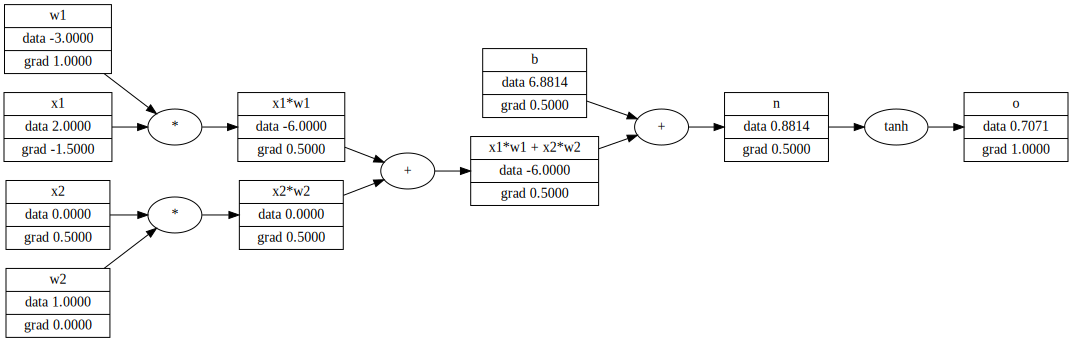

In [206]:
draw_dot(o)

Automate Backprop

In [214]:
class Value:

    def __init__(self, data, _children=(), _op='', label='', ):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad = other.data * out.grad
            other.gard = self.grad * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1- t**2) * out.grad
        out._backward = _backward

        return out
    
a = Value(2.0, label='a')
b = Value(3.0, label='b')
c = Value(4.0, label='c')

e = a*b; e.label='e'
e
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data=-20.0)

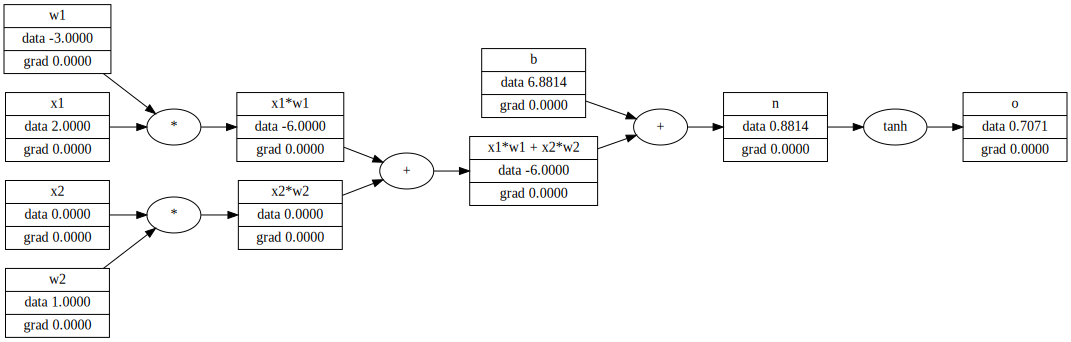

In [235]:
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias
b = Value(6.88137358, label='b')

#output
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

In [218]:
o.grad = 1.0
o._backward()

In [220]:
n._backward()

In [222]:
b._backward()

In [224]:
x1w1x2w2._backward()

In [226]:
x1w1._backward()

In [227]:
x2w2._backward()

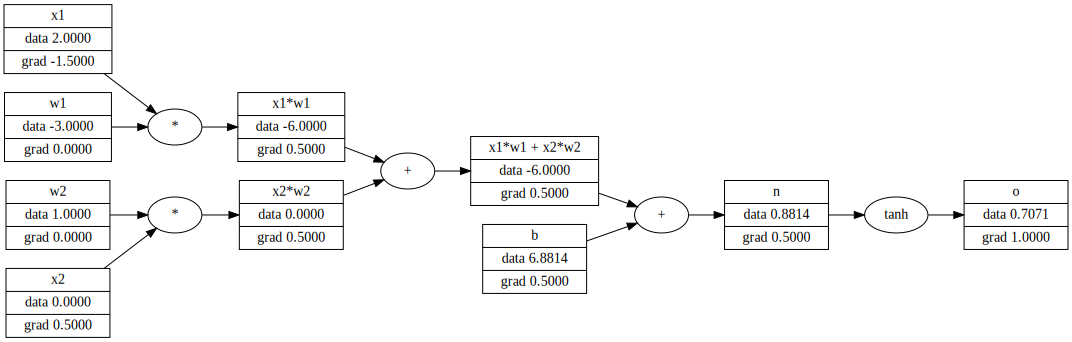

In [228]:
draw_dot(o)

Topological Graph: Topological Sort: 

To call backward for a node only when all children are calc

In [236]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo
for node in reversed(topo):
    node._backward()


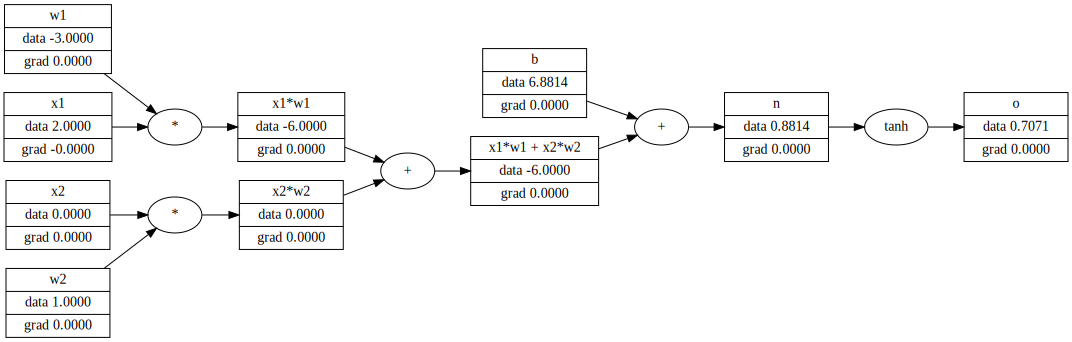

In [237]:
draw_dot(o)